In [1]:
#libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pandas_profiling import ProfileReport

from pandas_datareader import data as pdr
import yfinance

from statsmodels.tsa.statespace.varmax import VARMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from sklearn import metrics
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import r2_score
from statsmodels.tsa.arima.model import ARIMA

from timeit import default_timer as timer
from dateutil.parser import parse
from datetime import datetime
import warnings

warnings.filterwarnings('ignore')

In [2]:
data = pdr.get_data_yahoo('MSFT', start='2019-01-01', end='2019-12-31')
data = data['Close']

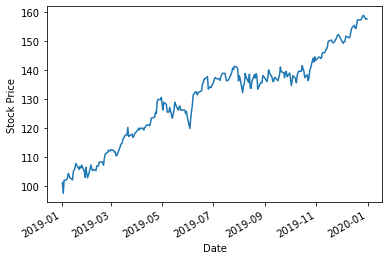

In [3]:
ax = data.plot()
ax.set_ylabel('Stock Price')
plt.show()

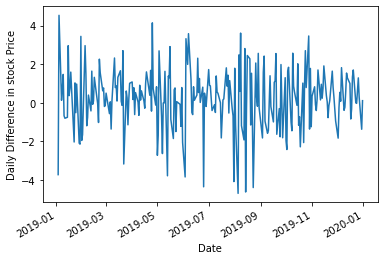

In [4]:
#Need to difference
differenced_data = data.diff().dropna()
ax = differenced_data.plot()
ax.set_ylabel('Daily Difference in stock Price')
plt.show()

In [5]:
result = adfuller(differenced_data)
print(result)

pvalue = result[1]

if pvalue < 0.05:
    print('stationary')
else:
    print('not stationary')

(-8.556434017225028, 8.93327814547054e-14, 5, 245, {'1%': -3.4573260719088132, '5%': -2.873410402808354, '10%': -2.573095980841316}, 867.2296047900045)
stationary


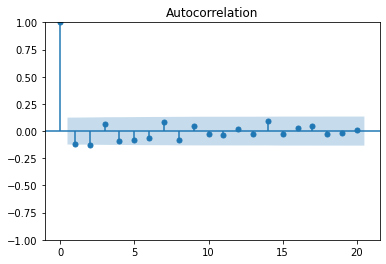

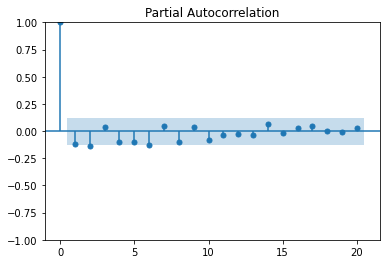

In [6]:
plot_acf(differenced_data, lags=20)
plot_pacf(differenced_data, lags=20)
plt.show()

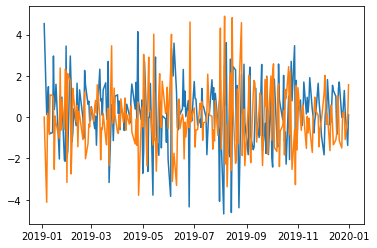

In [7]:
#Forecast the first MA(1) model
mod = ARIMA(differenced_data.diff().dropna(), order=(0,0,1))
res = mod.fit()

#orig_data = data.diff().dropna()
orig_data = differenced_data.dropna()
pred = res.predict()

plt.plot(orig_data[1:])
plt.plot(pred)
plt.show()

In [8]:
print(r2_score(orig_data[1:],pred))

-0.8402381694047136


### Train-Test Evaluation and Tuning

In [9]:
train = data.diff().dropna()[0:240]
test = data.diff().dropna()[240:250]

#Forecast the first MA(1) model
mod = ARIMA(train, order=(0,0,1))
res = mod.fit()

orig_data = data.diff().dropna()
pred = res.predict()
fcst = res.forecast(steps=len(test))

print(r2_score(train, pred))
print(r2_score(test, fcst))

0.018509841130868954
-0.046131198582131994


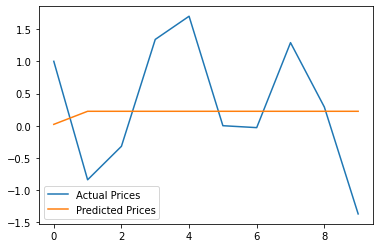

In [10]:
plt.plot(list(test))
plt.plot(list(fcst))
plt.legend(['Actual Prices', 'Predicted Prices'])
plt.show()

-0.04379229674107199


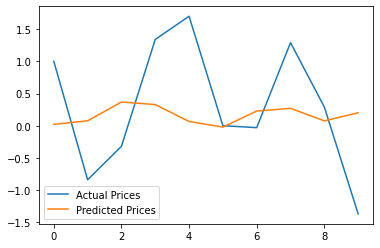

In [14]:
train = data.diff().dropna()[0:240]
test = data.diff().dropna()[240:250]

fcst = []

for step in range(len(test)):
    mod = ARIMA(train.reset_index(drop=True), order=(0,0,1))
    res = mod.fit()
    
    fcst += list(res.forecast(steps=1))
    train = train.append(pd.Series(test[step]))

print(r2_score(list(test), fcst))

plt.plot(list(test))
plt.plot(list(fcst))
plt.legend(['Actual Prices', 'Predicted Prices'])
plt.show()


### Grid Search to Find the Best MA Order

In [16]:
def evaluate2(order):

    train = data.diff().dropna()[0:240]
    test = data.diff().dropna()[240:250]

    fcst = []

    for step in range(len(test)):
        #Forecast the first MA(1) model
        mod = ARIMA (train.reset_index(drop=True), order=(0,0,order))
        res = mod.fit()
        orig_data = data.diff().dropna()
        pred = res.predict()
        fcst += list(res.forecast(steps = 1))
        train = train.append(pd.Series(test[step]))

    return r2_score(list(test), fcst)

scores = []

for i in range(1,21):
    scores.append((i,evaluate2(i)))

#Observe best order is 4 with R2 of 0.566
scores = pd.DataFrame(scores)
print(scores[scores[1] == scores.max()[1]])

   0         1
2  3  0.081563


-0.11416765515370719


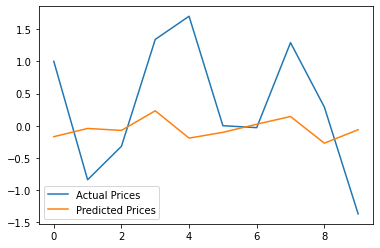

In [17]:
train = data.diff().dropna()[0:240]
test = data.diff().dropna()[240:250]

fcst = []

for step in range(len(test)):
    #Forecast the first MA(1) model
    mod = ARIMA (train.reset_index(drop=True), order=(0,0,4))
    res = mod.fit()
    orig_data = data.diff().dropna()
    pred = res.predict()
    fcst += list(res.forecast(steps = 1))
    train = train.append(pd.Series(test[step]))

print(r2_score(list(test), fcst))

plt.plot(list(test))
plt.plot(list(fcst))
plt.legend(['Actual Prices', 'Predicted Prices'])
plt.show()